# Canadian Housing Archetype Analysis: Example Workbook

This notebook provides an introduction to the Canadian Housing Archetypes dataset, and example analysis illustrating their use in residential energy analysis. 

## Introduction

The Canadian Housing Archetypes are a database of representing 6809 residential homes. The data have been sampled from audit data collected through the EnerGuide for Housing Labelling program. A stastical method was used to select these records so that the resulting subset contains representative distributions by province and fuel type.

## Acknowledgements

- Rasoul Asaee (Natural Resources Canada) developed the archetypes, using methods originally proposed by Lucas Swan (Dalhousie   University)
- Leigh St. Hilaire and Aiden Brookson (Volta Research) developed the data schema. 



## Architecture

The original archetype audit data is stored in XML format, using the HOT2000 data schema (`.h2k`). These files are located in the `data / h2k_files` directory.  The contents of these files has been extracted and reformatted into a csv-based data schema to aid analysis.


The archetype data is contained in three `.csv` files: 
- `archetype_descriptions.csv` contains general information describing each the geometry and thermal characteristics of the archetypes
- `extra_data_windows.csv` contains expanded descriptions for archetype window characteristics, areas and orientations
- `extra_data_heating_sys.csv` contains descriptions for supplementary heating systems

Each of these files contains a common field `filename` that can be used to merge them. A fourth file, `energy-reusults.csv` contains estimated energy consumption data obtained by processing the data with HOT20000.


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults 

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,5)

#sns.set(palette="colorblind", style="ticks", context="notebook")

# Load archetype data table into dataframes, 
# Note: Setting `low_memory = False` enables python to 
#       load large datasets without warning the user

df_base = pd.read_csv('../../data/tables/archetype_descriptions.csv', low_memory = False)
df_windows = pd.read_csv('../../data/tables/extra_data_windows.csv', low_memory = False)
df_supp_heat = pd.read_csv('../../data/tables/extra_data_heating_sys.csv',low_memory = False)

# `prov_o` is a list used to control the order that provinces are displayed in  charts. 
prov_o = ['British Columbia','Alberta','Saskatchewan','Manitoba','Ontario','Quebec',
          'New Brunswick','Nova Scotia','Prince Edward Island',
          'Yukon','Northwest Territories']

colours_heating_fuel = {'Electric':'tab:green',  'Natural gas':'tab:blue','Oil':'tab:orange','no data':'tab:gray', 'Propane':'tab:red', 'Wood':'tab:brown'}

## Characteristics of the archetype set


#### Distribution by Province
The archetypes are drawn from all Canadian provinces and territories, with the exception of Newfoundland and Iqualuit. These omissions reflect underrepresentation of those jurisdictions in the Energuide database.

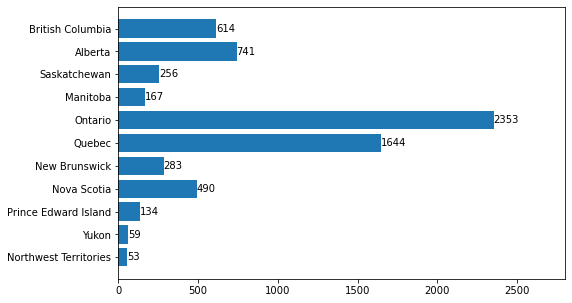

In [2]:
# Use crosstab to compute the frequency of archetypes by province
ctab = pd.crosstab(index=df_base['province'], columns=[1])
ctab = ctab.reindex(prov_o, axis='rows')  # Re-order provinces by prov_o

# Draw horizontal bar chart showing distribution by province
fig, ax = plt.subplots()
hbars = ax.barh(ctab.index, ctab[1], align='center')
ax.invert_yaxis() # Put BC at the top
ax.bar_label(hbars, fmt='%.0f') # Label bars
ax.set_xlim(right=2800) #shift axis limit

plt.show()



Within each province and territory, the archetypes are drawn from major cities and rural centres. The following plot illustrates distribution of archetypes by city, for the three prarie provinces. Note that data for Alberta contains a disproportional number of records from Edmonton (pop 1.0M) relative to Calgary (pop. 1.3M)

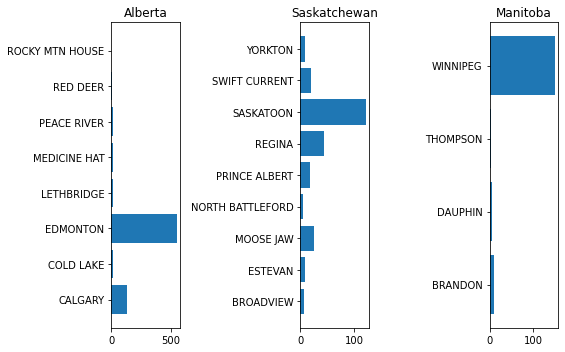

In [3]:
# Subset prarie provinces


# Create a figure with three subplots
fig, ax = plt.subplots(1,3)

# Use cross tab to compute frequency of locations in each province; 
# add bar-plot to figure. 

# For Alberta, 
ctab = pd.crosstab(index=df_base[(df_base['province'] == 'Alberta')]['location'], columns=[1])
hbars = ax[0].barh(ctab.index, ctab[1], align='center')
ax[0].title.set_text('Alberta')

# ... Saskatchewan,
ctab = pd.crosstab(index=df_base[(df_base['province'] == 'Saskatchewan')]['location'], columns=[1])
hbars = ax[1].barh(ctab.index, ctab[1], align='center')
ax[1].title.set_text('Saskatchewan')


# ... & Manitoba.
ctab = pd.crosstab(index=df_base[(df_base['province'] == 'Manitoba')]['location'], columns=[1])
hbars = ax[2].barh(ctab.index, ctab[1], align='center')
ax[2].title.set_text('Manitoba')

# Call 'tight_layout()' to fix wonky subplot spacing.
fig.tight_layout()



#### Distribution by vintage
The archetypes are also distributed by vintage. The oldest home in the set was constructed in 1790, the newest in 2019. Most of the records reflect homes built since after 1950. The age of each archetype is described in column `vintageExact`.

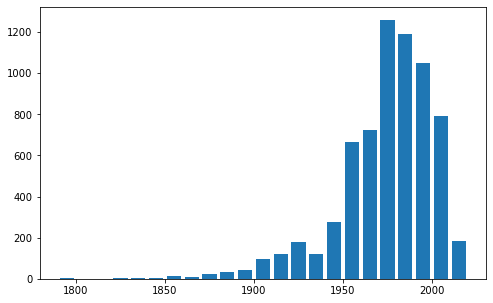

In [4]:
fig, ax = plt.subplots()
w=10
vintages = df_base['vintageExact'] 
bin_list = np.arange(min(vintages), max(vintages)+w,w)
hist = ax.hist(x=df_base['vintageExact'], bins=bin_list, rwidth=0.8)


Within each province, the archetypes may exhibit somewhat different vintage distributions. 


#### Heating fuels

The archetypes are heated using a mix of different systems

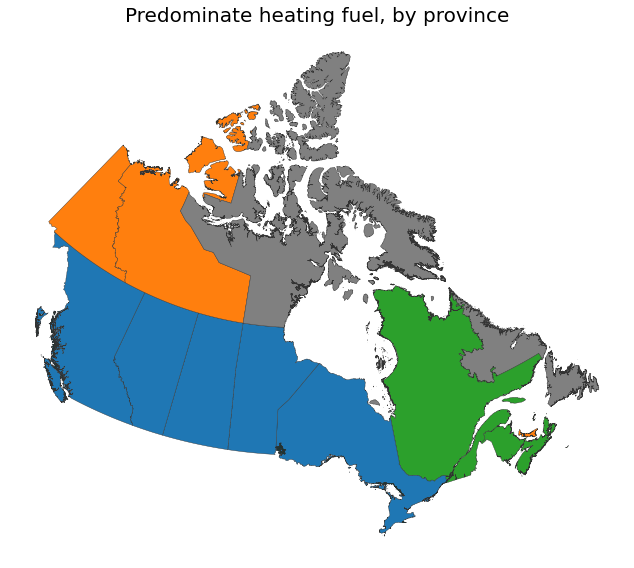

In [5]:
import geopandas as gpd

can = gpd.read_file("../../data/shape_files/CAD-prov/lpr_000b16a_e.shp") 

predom_fuel = df_base.groupby('province')['heatingFuelPrimary'].apply(lambda x: x.value_counts().index[0]).reset_index()

#print(predom_fuel)


can['heatingFuelPrimary'] = 'no data'
can['colours'] = 'gray'


for prov in prov_o:
    fuel = predom_fuel.loc[(predom_fuel['province'] == prov),'heatingFuelPrimary']
    can.loc[(can['PRENAME']==prov),'heatingFuelPrimary'] = fuel.values[0]
    can.loc[(can['PRENAME']==prov),'colours'] = 'green'
    can.loc[(can['PRENAME']==prov),'colours'] = colours_heating_fuel[fuel.values[0]]



#print(predom_fuel[predom_fuel['province'] == 'ALBERTA','heatingFuelPrimary'])
#print(predom_fuel.loc(predom_fuel['province'] == 'ALBERTA')['heatingFuelPrimary'])

#

#can.loc(can['PRNAME']=='Alberta')['heatingFuelPrimary'] = predom_fuel.loc(predom_fuel['province'] == 'ALBERTA')['heatingFuelPrimary']

#print(can[['PRNAME','heatingFuelPrimary']])

fig, ax = plt.subplots(1,figsize=(14,8))
can.plot(categorical=True, linewidth=0.4,edgecolor='0.2',legend=True, color=can['colours'], label=can['heatingFuelPrimary'], ax=ax)
#can.plot(column='heatingFuelPrimary', categorical=True, linewidth=0.4,edgecolor='0.2',legend=True) 
#ax.legend(can['heatingFuelPrimary', colours_heating_fuel)
ax.axis('off')
ax.set_title('Predominate heating fuel, by province',fontsize=20)

plt.tight_layout()
plt.show()

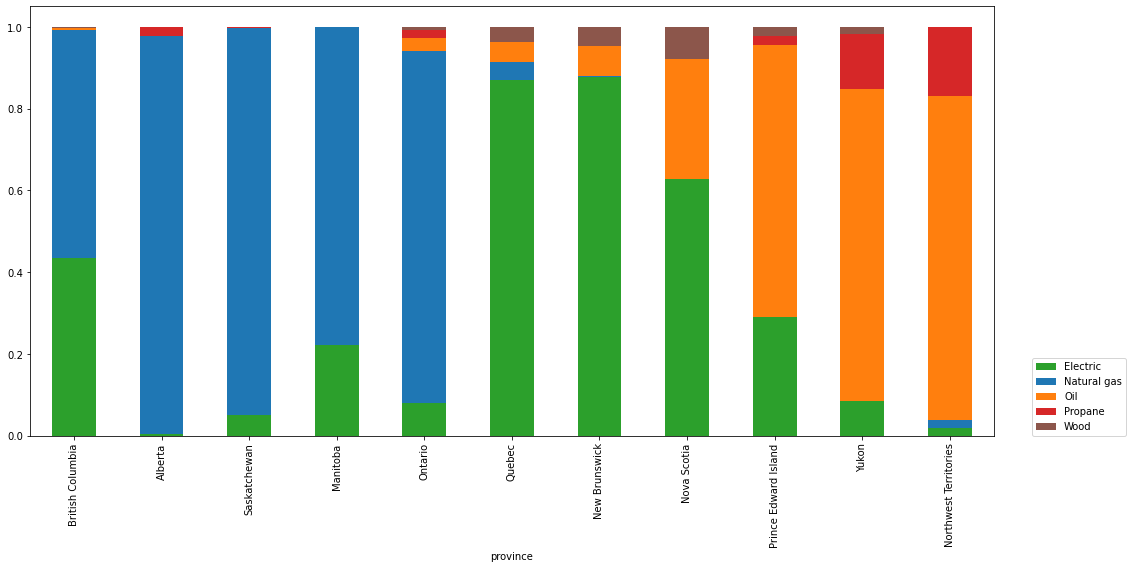

In [6]:
# Get a list of the predominate heating fuels bny province
predom_fuel = df_base.groupby('province')['heatingFuelPrimary'].apply(lambda x: x.value_counts().index[0]).reset_index()


ctab = pd.crosstab(index=df_base['province'], 
                   columns=df_base['heatingFuelPrimary'],
                   normalize='index')

ctab = ctab.reindex(prov_o, axis='rows')
fig, ax = plt.subplots(1,figsize=(14,8))
ctab.plot(kind='bar',stacked=True,color = colours_heating_fuel, ax=ax)
plt.tight_layout()
plt.legend(loc=(1.04,0))
plt.show()


In [7]:

def make_spider(df, row, color, title):
    
    categories=list(df)[0:]
    N = len(categories)

    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    plt.rc('figure', figsize=(12, 12))
 
    ax = plt.subplot(1,1,1, polar=True)
 
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
 
   
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.tick_params(axis='x', rotation=5.5)
    
    ax.set_rlabel_position(0)
    plt.yticks([20,40,60,80], ["20","40","60","80"], color="black", size=10)
    plt.ylim(0,100)
 
    
    values=df.reset_index().loc[row].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth=1, linestyle='solid')
    ax.fill(angles, values, color = color, alpha = 0.5)
 
  
    title = "Radar showing performance in each subject for "+ title
    plt.title(title, fontsize=20, x = 0.5, y = 1.1)
 







In [8]:
df_window_area = df_base[["windowAreaN","windowAreaNE","windowAreaE","windowAreaSE","windowAreaS","windowAreaSW","windowAreaW","windowAreaNW"]]


print(df_window_area.mean())


#ctab = pd.crosstab(index=df_base['province'], columns=df_base['heatingFuelPrimary'],normalize='index')

#ctab = pd.pivot_table(df_window_area, aggfunc='mean')
#print(ctab)

windowAreaN     3.695754
windowAreaNE    1.655314
windowAreaE     3.558407
windowAreaSE    1.579610
windowAreaS     4.167063
windowAreaSW    1.737261
windowAreaW     3.543919
windowAreaNW    1.513669
dtype: float64


['windowAreaN', 'windowAreaNE', 'windowAreaE', 'windowAreaSE', 'windowAreaS', 'windowAreaSW', 'windowAreaW', 'windowAreaNW']
(8,)
(9,)
[3.69575441 1.65531392 3.55840732 1.57960968 4.16706313 1.73726056
 3.54391917 1.51366854 3.69575441]


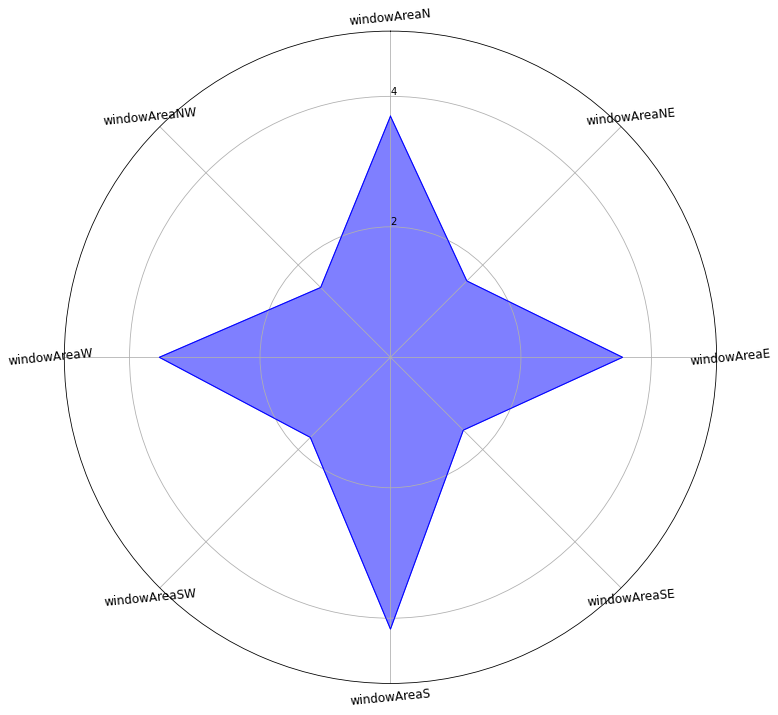

In [9]:





from math import pi
categories=list(df_window_area)[0:]
print(categories)
N=len(categories)

values =np.array(df_window_area.mean().array)
print(values.shape)
values = np.append(values,values[0])
print(values.shape)
print(values)

row = 0
    
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
plt.rc('figure', figsize=(12, 12))
ax = plt.subplot(1,1,1, polar=True)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)


plt.xticks(angles[:-1], categories, color='black', size=12)
ax.tick_params(axis='x', rotation=5.5)

ax.set_rlabel_position(0)
plt.yticks([2,4,6,8], ["2","4","6","8"], color="black", size=10)
plt.ylim(0,int(values.max())+1)


#values=df_window_area.reset_index().loc[row].values.tolist()[1:]
#values += values[:1]
#print(values)

#values = df_window_area.mean().array


color = 'blue'

ax.plot(angles, values, color = color, linewidth=1, linestyle='solid')
ax.fill(angles, values, color = color, alpha = 0.5)
title = "none"

#title = "Radar showing performance in each subject for "+ title
#plt.title(title, fontsize=20, x = 0.5, y = 1.1)
 

#plt.figure()
#make_spider(df=df_ext)

### Q2) What characteristics do the archetypes exhibit?

#### Examine maximum, minimum and means for key descriptors

This block uses the `.describe()` method to examine vintage, floor area and window area

In [10]:
df_base[['vintageExact', 'totFloorArea', 'totWindowArea' ]].describe()

,vintageExact,totFloorArea,totWindowArea
count,6794.000000,6794.000000,6794.000000
mean,1973.213571,216.472152,21.694324
std,27.776317,125.046422,12.323546
min,1790.000000,30.300000,0.999488
25%,1960.000000,153.800000,13.950295
50%,1978.000000,198.600000,18.745125
75%,1992.000000,257.100000,26.158279
max,2019.000000,2640.300000,159.263568


#### Distribution of all archetypes, by vintage

Create a histogram showing the distribtion of archetypes by year

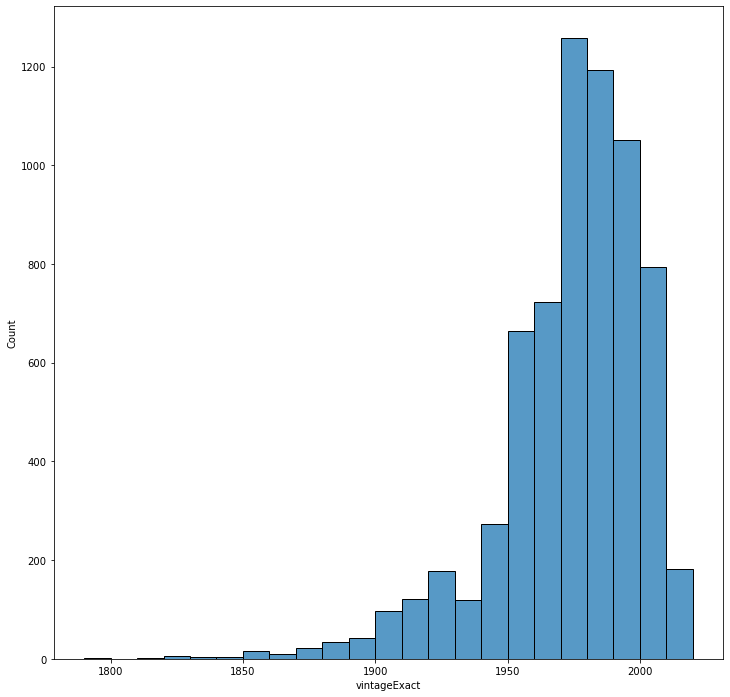

In [11]:
g = sns.histplot(data=df_base, x='vintageExact', binwidth = 10 )

### Distribution of archetypes by province and vintage

How does representation by vintage compare between provinces? This code plots the distribution of archetypes by vintage for Alberta and Nova Scotia, and then compares them to the national set. 

C:\Users\aferguso\AppData\Local\Temp\ipykernel_25992\2986900050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  national['Region'] = 'Canada'


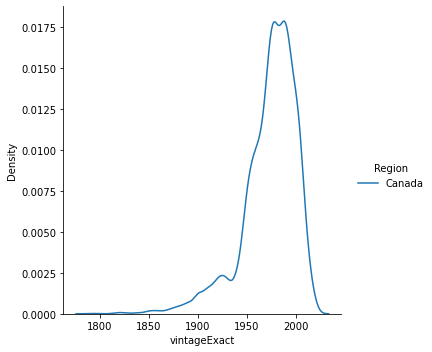

In [12]:
national = df_base[["vintageExact"]]
national['Region'] = 'Canada'

prov1 = df_base.loc[(df_base['province'] == 'ALBERTA'), ['vintageExact']]
prov1['Region'] = 'Alberta'

prov2= df_base.loc[(df_base['province'] == 'NOVA SCOTIA'), ['vintageExact']]
prov2['Region'] = 'Nova Scotia'


data_for_plot = pd.concat([national,prov1,prov2])

g = sns.displot(
  data_for_plot, x='vintageExact', kind='kde', hue = 'Region',  common_norm=False
)



> **Observation:** Nova Scotia distribution is similar to national average, but Alberta archetypes skew towards recent years.

#### Classify homes by commonly-used vintage bins & housing types

### Size of homes 

How has the size of homes changed over time? Plot size of single family homes by period.


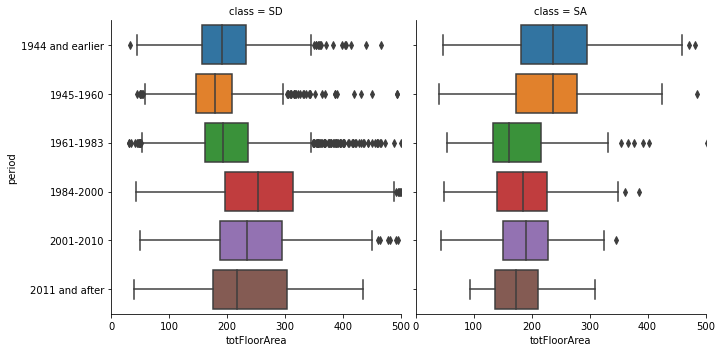

In [13]:
df_floor_area = df_base[(df_base['period'] != '1944 and earlier') & (df_base['period'] != '2011 and after') ] 
df_floor_area = df_base
period_order = np.sort(df_floor_area['period'].unique()) #.sort()

g=sns.catplot(data=df_floor_area[(df_floor_area['class']=='SD') | (df_floor_area['class']=='SA')] , order=period_order,
               y='period',x='totFloorArea', kind='box', col='class')
g.set(xlim=(0,500))
None



> **Observations**: Single family homes built since the mid-80's are larger than thise built earlier.  Attached homes appear to show the opposite trend. Attached result is surprising, but results appear significant (SA, Pre-1944 set = 253 archetypes; SA, 1945-1960 set = 189 archetypes.

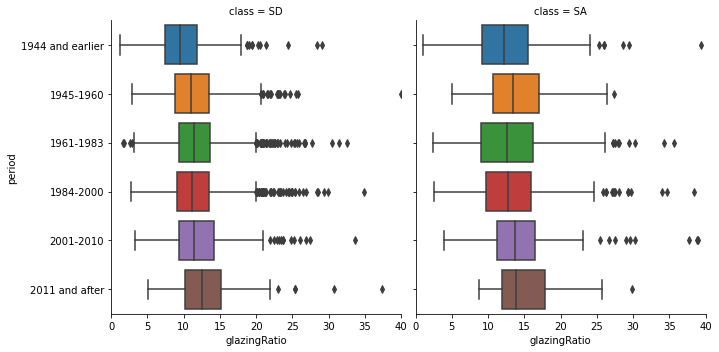

In [14]:
df_glr = df_base[(df_base['period'] != '1944 and earlier') & (df_base['period'] != '2011 and after') ] 
df_glr = df_base

g=sns.catplot(data=df_glr[(df_floor_area['class']=='SD') | (df_floor_area['class']=='SA')] , order=period_order,
               y='period',x='glazingRatio', kind='box', col='class')

g.set(xlim=(0,40))

None


### Air-tightness trends
How has air-tightness changed over time? And how do those trends compare by province? Omit the post 2011 records, because there are few archetypes in those periods. 

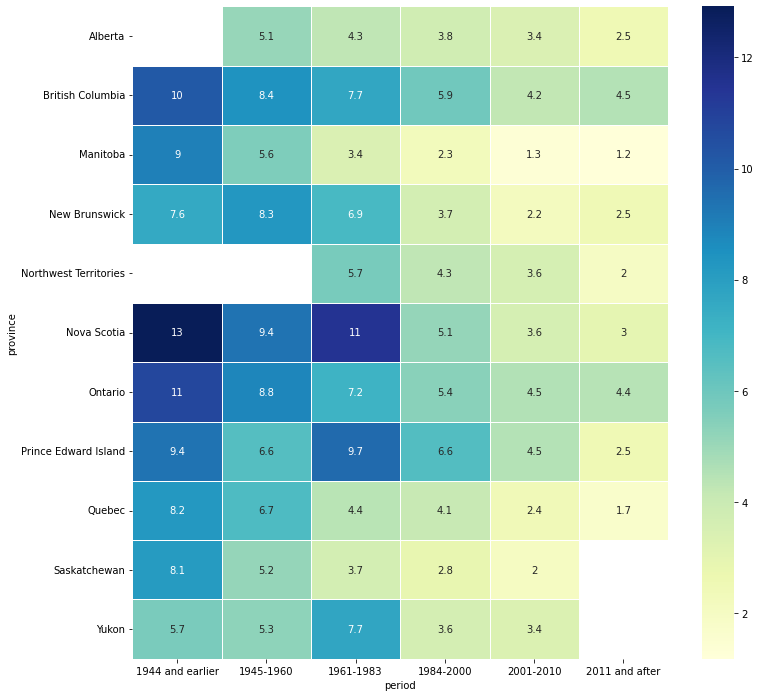

In [15]:
df_ach = df_base.pivot_table(index='province',columns='period',values='ach', aggfunc='median')
g=sns.heatmap(df_ach, annot=True, linewidths = 0.5, cmap="YlGnBu")

>**Observations**: New construction has become progressively more air-tight since the 1980's.


#### Investigate house sizes in different Albertan cities (using above grade floor area as the metric of size)

In [16]:
df_base[df_base['province'] == 'ALBERTA'].groupby('location')['agFloorArea'].describe().fillna(0)

ValueError: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.base.Index'> was passed

### Investigate main wall insulation by decade in Ontario from 1900 onwards

In [ ]:
on1900Df = df[(df['province'] == 'ONTARIO') & (df['decade'] >= 1900)]

plt.figure(figsize=(16, 8))
wallRValPlt = sns.boxplot(
    x = 'decade', 
    y = 'dominantWallRVal', 
    data = on1900Df,
    palette = sns.color_palette('husl',11),
    showfliers = True,
    whis = 1.5,
    showmeans=True,
    meanprops={
        'marker':'o', 
        'markerfacecolor':'white', 
        'markeredgecolor':'black', 
        'markersize':8
    }
)



wallRValPlt.axes.set_title("Main Wall Insulation by Decade in Ontario",fontsize=20)
wallRValPlt.set_xlabel("Decade",fontsize=15)
wallRValPlt.set_ylabel("Main Wall R-value (RSI)",fontsize=15)
wallRValPlt.tick_params(labelsize=12)
plt.show()

#### Display descriptive statistics of the above plot

In [ ]:
on1900Df.groupby('decade')['dominantWallRVal'].describe()

#### Alternative way to visualize wall R-value by vintage in Ontario

In [ ]:
plt.figure(figsize=(16, 8))
for decade in sorted(on1900Df['decade'].unique()):
    wallDistPlt = sns.distplot(
        on1900Df[on1900Df['decade'] == decade][['dominantWallRVal']], 
        hist=False, 
        label = f'{decade}s'
    )
    
wallDistPlt.axes.set_title("Main Wall Insulation Distribution by Decade in Ontario",fontsize=20)
wallDistPlt.set_xlabel("Wall Insulation (RSI)",fontsize=15)
wallDistPlt.set_ylabel("Frequency",fontsize=15)
wallDistPlt.legend(fontsize=15)
wallDistPlt.tick_params(labelsize=12)

### Investigate airtightness over time in British Columbia

In [ ]:
bc1900Df = df[(df['province'] == 'BRITISH COLUMBIA') & (df['decade'] >= 1900)]

In [ ]:
plt.figure(figsize=(16, 8))
achBcPlt = sns.boxplot(
    x = 'decade', 
    y = 'ach', 
    data = bc1900Df,
    palette = sns.color_palette('husl',11),
    showfliers = True,
    whis = 1.5,
    showmeans=True,
    meanprops={
        'marker':'o', 
        'markerfacecolor':'white', 
        'markeredgecolor':'black', 
        'markersize':8
    }
)

achBcPlt.axes.set_title("Airtightness by Decade in British Columbia",fontsize=20)
achBcPlt.set_xlabel("Decade",fontsize=15)
achBcPlt.set_ylabel("Air Change Rate (ach50)",fontsize=15)
achBcPlt.tick_params(labelsize=12)

#### Get table of descriptive statistics of the above plot

In [ ]:
bc1900Df.groupby('decade')['ach'].describe()

#### Alternative way to visualize wall ACH by vintage in British Columbia

In [ ]:
plt.figure(figsize=(16, 8))
for decade in sorted(bc1900Df['decade'].unique()):
    if len(bc1900Df[bc1900Df['decade'] == decade][['ach']]) < 2:
        continue
    achDistPlt = sns.distplot(
        bc1900Df[bc1900Df['decade'] == decade][['ach']], 
        hist=False, 
        label = f'{decade}s'
    )
    
achDistPlt.axes.set_title("Airtightness Distribution by Decade in British Columbia",fontsize=20)
achDistPlt.set_xlabel("Air Change Rate (ach50)",fontsize=15)
achDistPlt.set_ylabel("Frequency",fontsize=15)
achDistPlt.legend(fontsize=15)
achDistPlt.tick_params(labelsize=12)

### Investigate Mechanical Systems

In [ ]:
df.groupby('province')['spaceHeatingFuel'].value_counts().unstack().fillna(0)

In [ ]:
plt.figure(figsize=(16, 12))
heatingFuelDf = (df.groupby(['province'])['spaceHeatingFuel']
                    .value_counts(normalize=True)
                    .rename('percentage')
                    .mul(100)
                    .reset_index()
                    .sort_values('spaceHeatingFuel'))

heatingFuelPlt = sns.barplot(x='percentage', y='province', data=heatingFuelDf, hue='spaceHeatingFuel')
heatingFuelPlt.axes.set_title("Heating Fuel Percent by Province",fontsize=20)
heatingFuelPlt.set_xlabel("Heating Fuel Percentage (%)",fontsize=15)
heatingFuelPlt.set_ylabel("Province",fontsize=15)
heatingFuelPlt.legend(fontsize=15)
heatingFuelPlt.tick_params(labelsize=12)